# RFD3 partial diffusion on GPC3 minibinder hits from BindCraft

In [ ]:
import numpy as np
from rfd3.engine import RFD3InferenceConfig, RFD3InferenceEngine

04:44:51 DEBUG transforms: Debug mode is on


In [ ]:
from biotite.structure import get_residue_starts
from biotite.sequence import ProteinSequence
from atomworks.io.utils.visualize import view
from atomworks.io.utils.io_utils import to_cif_file

In [ ]:
config = RFD3InferenceConfig(
    specification={
        "dialect": 2,
        "input": "/paperspace/Desktop/cancer/gpc3/run_23/gpc3_out_1_l108_s599292_mpnn3_model2_relaxed.pdb",
        "contig": "A1-291,/0,B1-108",
        "select_fixed_atoms": "A1-291",
        "select_unfixed_sequence": "B1-108",
        "is_non_loopy": True,
        "infer_ori_strategy": "hotspots",
        "select_hotspots": "A36,A48,A59,A81,A86,A89,A99",
        "partial_t": 15
    },
    diffusion_batch_size=1,
)

model = RFD3InferenceEngine(**config)
outputs = model.run(
    inputs=None,
    out_dir=None,
    n_batches=1,
)

first_key = next(iter(outputs.keys()))
atom_array = outputs[first_key][0].atom_array

res_starts = get_residue_starts(outputs[first_key][0].atom_array)
seq_1letter = ''.join(
        ProteinSequence.convert_letter_3to1(res_name)
        for res_name in outputs[first_key][0].atom_array.res_name[res_starts]
    )
print(f"Sequence {seq_1letter}")

# Export structures to CIF format for visualization in PyMOL/ChimeraX
to_cif_file(atom_array, "generated.cif")

view(atom_array)

Using bfloat16 Automatic Mixed Precision (AMP)
12:08:25 WARNING atomworks.io: We can't fix formal charges without building from templates, as we need to know the true number of hydrogens bonded to a given atom, not the inferred number. This may lead to occasional inaccuracies after adding inter-residue bonds. To avoid this and fix formal charges, set `add_missing_atoms = True`.
12:08:26 WARNING atomworks.io: The `extra_fields` argument will be ignored if there is no CIF file input.
12:08:26 WARNING atomworks.ml: Cached data not found for ALA at /net/tukwila/ncorley/datahub/MACE-OFF23_medium/A/ALA/ALA.pt
12:08:26 WARNING atomworks.ml: Cached data not found for ARG at /net/tukwila/ncorley/datahub/MACE-OFF23_medium/A/ARG/ARG.pt
12:08:26 WARNING atomworks.ml: Cached data not found for ASN at /net/tukwila/ncorley/datahub/MACE-OFF23_medium/A/ASN/ASN.pt
12:08:26 WARNING atomworks.ml: Cached data not found for ASP at /net/tukwila/ncorley/datahub/MACE-OFF23_medium/A/ASP/ASP.pt
12:08:26 WARNING 

Sequence GSDLQVCLPKGPTCCSRKMEEKYQLTARLNMEQLLQSASKELKFLIIQNAAVFQEAFEIVVRHAKNYTNAMFKNNYPSLTPQAFEFVGEFFTDVSLYILGSDINVDDMVNELFDSLFPVIYTQLMNPGLPDSALDINECLRGARRDLKVFGNFPKLIMTQVSKSLQVTRIFLQALNLGIEVINTTDHLKFSKDCGRMLTRMWYCSYCQGLMMVKPCGGYCNVVMQGCMAGVVEIDKYWREYILSLEELVNGMYRIYDMENVLLGLFSTIHDSIQYVQKNAGKLTTTIGKLCTLSSRRRELIQKLKSFISFYSALPGYICSHSPVAENDTLCWNGQELVERYSQAARNGMKNQFNLHELKMKGPEPVVSQIIDKLKHINQLLRTMSNDLALALATQLLSLTSALLATTPTNARLTFLENTGLSNAAIKSQAVLNALLNALVSTLNTACSLPGLAALPQINLAIGALALVALTATNLSIQSKAAATKSQILALLN


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
outputs[first_key][0].metadata

OrderedDict([('diffused_index_map', {}),
             ('metrics',
              {'max_ca_deviation': 0.25624537467956543,
               'n_chainbreaks': 0,
               'n_clashing.interresidue_clashes_w_sidechain': 5,
               'n_clashing.interresidue_clashes_w_backbone': 1,
               'non_loop_fraction': np.float64(0.7277227722772277),
               'loop_fraction': np.float64(0.2722772277227723),
               'helix_fraction': np.float64(0.698019801980198),
               'sheet_fraction': np.float64(0.0297029702970297),
               'num_ss_elements': 10,
               'radius_of_gyration': np.float64(29.63037513475233),
               'alanine_content': np.float64(0.08113590263691683),
               'glycine_content': np.float64(0.05070993914807302),
               'num_residues': 493,
               'diffused_com': [-0.38189536333084106,
                1.7200661897659302,
                -2.2781193256378174],
               'fixed_com': [-4.440835952758789,


## Calculate RMSDs

## Test RMSDs

In [ ]:
from atomworks.io.utils.io_utils import load_any
from atomworks.constants import PROTEIN_BACKBONE_ATOM_NAMES
from biotite.structure import rmsd, superimpose
from atomworks.io.utils.visualize import view
import numpy as np

In [ ]:
ref = load_any("gpc3_out_1_l108_s599292_mpnn3_model2_relaxed.pdb")[0]
mob = load_any("rfd3_outputs/partial_diffusion_specification_7_model_1.cif.gz")[0]

In [ ]:
view(mob, height=800, width=1200)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
bb_mob = mob[np.isin(mob.atom_name, ['N', 'CA', 'C', 'O'])]
binder_bb_mob = bb_mob[np.isin(bb_mob.chain_id, "B")]

bb_ref = ref[np.isin(ref.atom_name, ['N', 'CA', 'C', 'O'])]
binder_bb_ref = bb_ref[np.isin(bb_ref.chain_id, "B")]

In [ ]:
binder_bb_mob_fitted, _ = superimpose(binder_bb_ref, binder_bb_mob)
rmsd_value = rmsd(binder_bb_ref, binder_bb_mob_fitted)
print(rmsd_value)

21.473122


## Calculate RMSDs

In [ ]:
from atomworks.io.utils.io_utils import load_any
from atomworks.constants import PROTEIN_BACKBONE_ATOM_NAMES
from biotite.structure import rmsd, superimpose
from atomworks.io.utils.visualize import view
import numpy as np
import glob

Environment variable CCD_MIRROR_PATH not set. Will not be able to use function requiring this variable. To set it you may:
  (1) add the line 'export VAR_NAME=path/to/variable' to your .bashrc or .zshrc file
  (2) set it in your current shell with 'export VAR_NAME=path/to/variable'
  (3) write it to a .env file in the root of the atomworks.io repository
Environment variable PDB_MIRROR_PATH not set. Will not be able to use function requiring this variable. To set it you may:
  (1) add the line 'export VAR_NAME=path/to/variable' to your .bashrc or .zshrc file
  (2) set it in your current shell with 'export VAR_NAME=path/to/variable'
  (3) write it to a .env file in the root of the atomworks.io repository


In [ ]:
def partial_diffusion_bb_rmsd(reference, mobile):
    ref = load_any(reference)[0]
    mob = load_any(mobile)[0]

    bb_mob = mob[np.isin(mob.atom_name, ['N', 'CA', 'C', 'O'])]
    binder_bb_mob = bb_mob[np.isin(bb_mob.chain_id, "B")]
    bb_ref = ref[np.isin(ref.atom_name, ['N', 'CA', 'C', 'O'])]
    binder_bb_ref = bb_ref[np.isin(bb_ref.chain_id, "B")]

    binder_bb_mob_fitted, _ = superimpose(binder_bb_ref, binder_bb_mob)
    rmsd_value = rmsd(binder_bb_ref, binder_bb_mob_fitted)
    return rmsd_value

In [ ]:
binder_bb_rmsds = []
files = glob.glob("rfd3_outputs_4/*.cif.gz")
for file_path in files:
    binder_bb_rmsds.append(partial_diffusion_bb_rmsd(reference="gpc3_out_1_l108_s599292_mpnn3_model2_relaxed.pdb", mobile=file_path))

np.savetxt('rfd3_outputs_4/binder_bb_rmsds_partial_diffusion_5.txt', binder_bb_rmsds)

### Analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
rmsd_15 = np.loadtxt("rfd3_outputs/binder_bb_rmsds_partial_diffusion_15.txt")
rmsd_20 = np.loadtxt("rfd3_outputs_1/binder_bb_rmsds_partial_diffusion_20.txt")
rmsd_25 = np.loadtxt("rfd3_outputs_2/binder_bb_rmsds_partial_diffusion_25.txt")
rmsd_10 = np.loadtxt("rfd3_outputs_3/binder_bb_rmsds_partial_diffusion_10.txt")
rmsd_5 = np.loadtxt("rfd3_outputs_4/binder_bb_rmsds_partial_diffusion_5.txt")

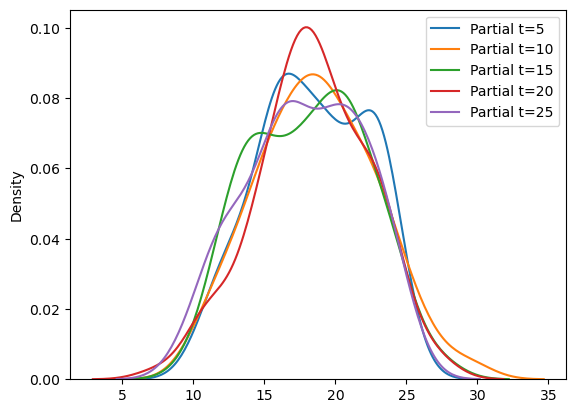

In [ ]:
sns.kdeplot(rmsd_5)
sns.kdeplot(rmsd_10)
sns.kdeplot(rmsd_15[:100])
sns.kdeplot(rmsd_20)
sns.kdeplot(rmsd_25)
plt.legend(['Partial t=5','Partial t=10', 'Partial t=15', 'Partial t=20', 'Partial t=25'])

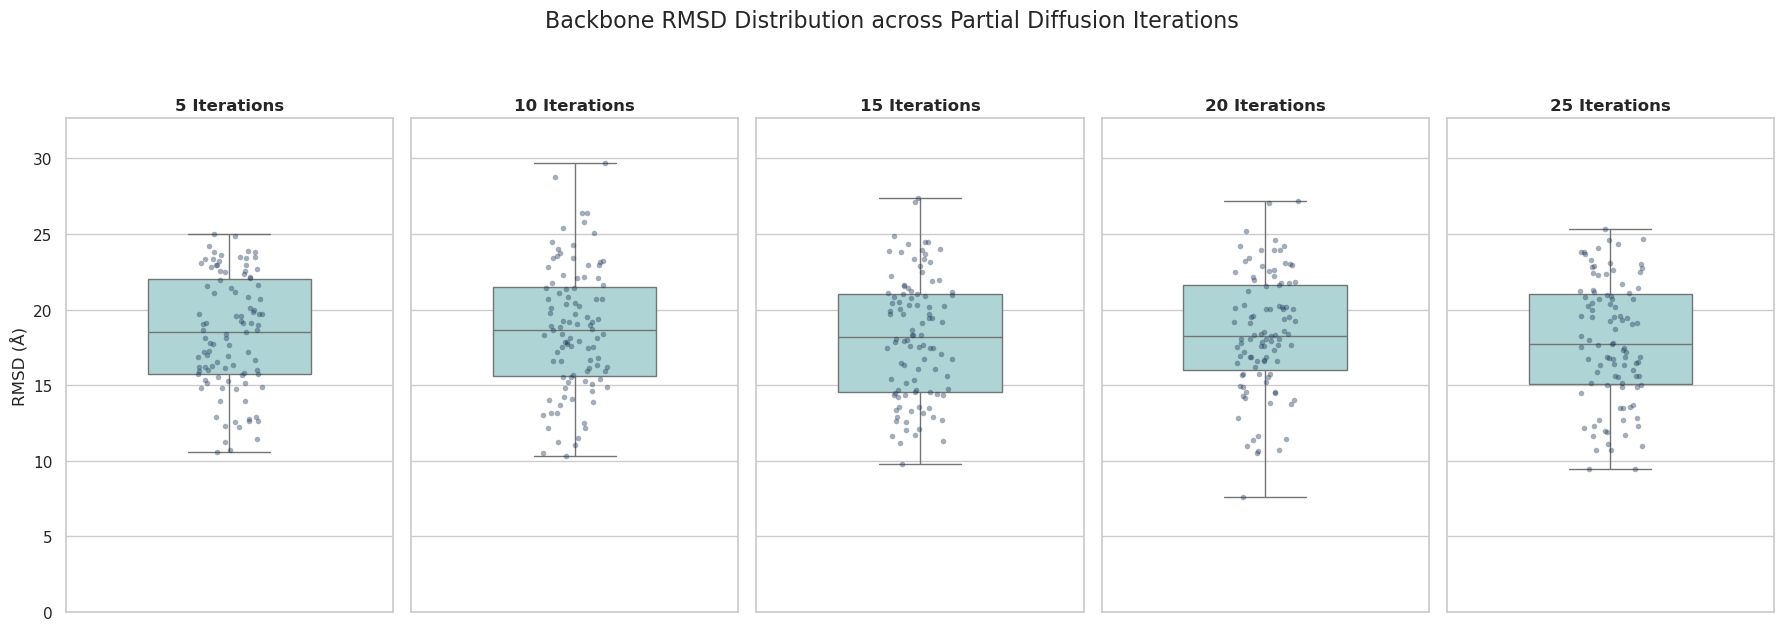

In [ ]:
# Set aesthetics
sns.set_theme(style="whitegrid")

# Data pairs - assuming variables rmsd_10, rmsd_15, rmsd_20, rmsd_25 are defined
rmsds = [rmsd_5, rmsd_10, rmsd_15[:100], rmsd_20, rmsd_25]
titles = ["5 Iterations", "10 Iterations", "15 Iterations", "20 Iterations", "25 Iterations"]
# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(18, 6), sharey=True)

for ax, data, title in zip(axes, rmsds, titles):
    # Main boxplot
    sns.boxplot(y=data, ax=ax, color='#a8dadc', width=0.5, showfliers=False)
    # Individual points
    sns.stripplot(y=data, ax=ax, color='#1d3557', alpha=0.4, jitter=True, size=4)
    
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel("RMSD (Å)") if ax == axes[0] else ax.set_ylabel("")
    ax.set_ylim(0, max([np.max(d) for d in rmsds]) * 1.1)

plt.suptitle("Backbone RMSD Distribution across Partial Diffusion Iterations", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

## Calculate RMSDs for enzymes

In [1]:
from atomworks.io.utils.io_utils import load_any
from atomworks.constants import PROTEIN_BACKBONE_ATOM_NAMES
from biotite.structure import rmsd, superimpose
from atomworks.io.utils.visualize import view
import numpy as np
import glob

Environment variable CCD_MIRROR_PATH not set. Will not be able to use function requiring this variable. To set it you may:
  (1) add the line 'export VAR_NAME=path/to/variable' to your .bashrc or .zshrc file
  (2) set it in your current shell with 'export VAR_NAME=path/to/variable'
  (3) write it to a .env file in the root of the atomworks.io repository
Environment variable PDB_MIRROR_PATH not set. Will not be able to use function requiring this variable. To set it you may:
  (1) add the line 'export VAR_NAME=path/to/variable' to your .bashrc or .zshrc file
  (2) set it in your current shell with 'export VAR_NAME=path/to/variable'
  (3) write it to a .env file in the root of the atomworks.io repository


In [2]:
def partial_diffusion_bb_rmsd(reference, mobile):
    ref = load_any(reference)[0]
    mob = load_any(mobile)[0]

    bb_mob = mob[np.isin(mob.atom_name, ['N', 'CA', 'C', 'O'])]
    binder_bb_mob = bb_mob[np.isin(bb_mob.chain_id, "A")]
    bb_ref = ref[np.isin(ref.atom_name, ['N', 'CA', 'C', 'O'])]
    binder_bb_ref = bb_ref[np.isin(bb_ref.chain_id, "A")]

    binder_bb_mob_fitted, _ = superimpose(binder_bb_ref, binder_bb_mob)
    rmsd_value = rmsd(binder_bb_ref, binder_bb_mob_fitted)
    return rmsd_value

In [3]:
binder_bb_rmsds = []
files = glob.glob("demo/outputs/*.cif.gz")
for file_path in files:
    binder_bb_rmsds.append(partial_diffusion_bb_rmsd(reference="demo/7v11.pdb", mobile=file_path))

np.savetxt('demo/outputs/demo_15A.txt', binder_bb_rmsds)

ValueError: operands could not be broadcast together with shapes (1,1157,3,1) (1,944,1,3) 

### Analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
rmsd_15 = np.loadtxt("rfd3_outputs/binder_bb_rmsds_partial_diffusion_15.txt")
rmsd_20 = np.loadtxt("rfd3_outputs_1/binder_bb_rmsds_partial_diffusion_20.txt")
rmsd_25 = np.loadtxt("rfd3_outputs_2/binder_bb_rmsds_partial_diffusion_25.txt")
rmsd_10 = np.loadtxt("rfd3_outputs_3/binder_bb_rmsds_partial_diffusion_10.txt")
rmsd_5 = np.loadtxt("rfd3_outputs_4/binder_bb_rmsds_partial_diffusion_5.txt")

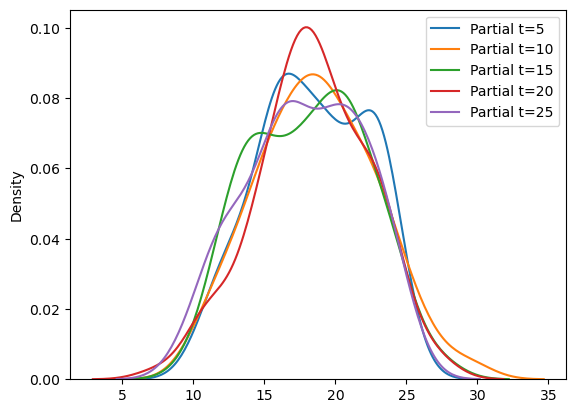

In [ ]:
sns.kdeplot(rmsd_5)
sns.kdeplot(rmsd_10)
sns.kdeplot(rmsd_15[:100])
sns.kdeplot(rmsd_20)
sns.kdeplot(rmsd_25)
plt.legend(['Partial t=5','Partial t=10', 'Partial t=15', 'Partial t=20', 'Partial t=25'])

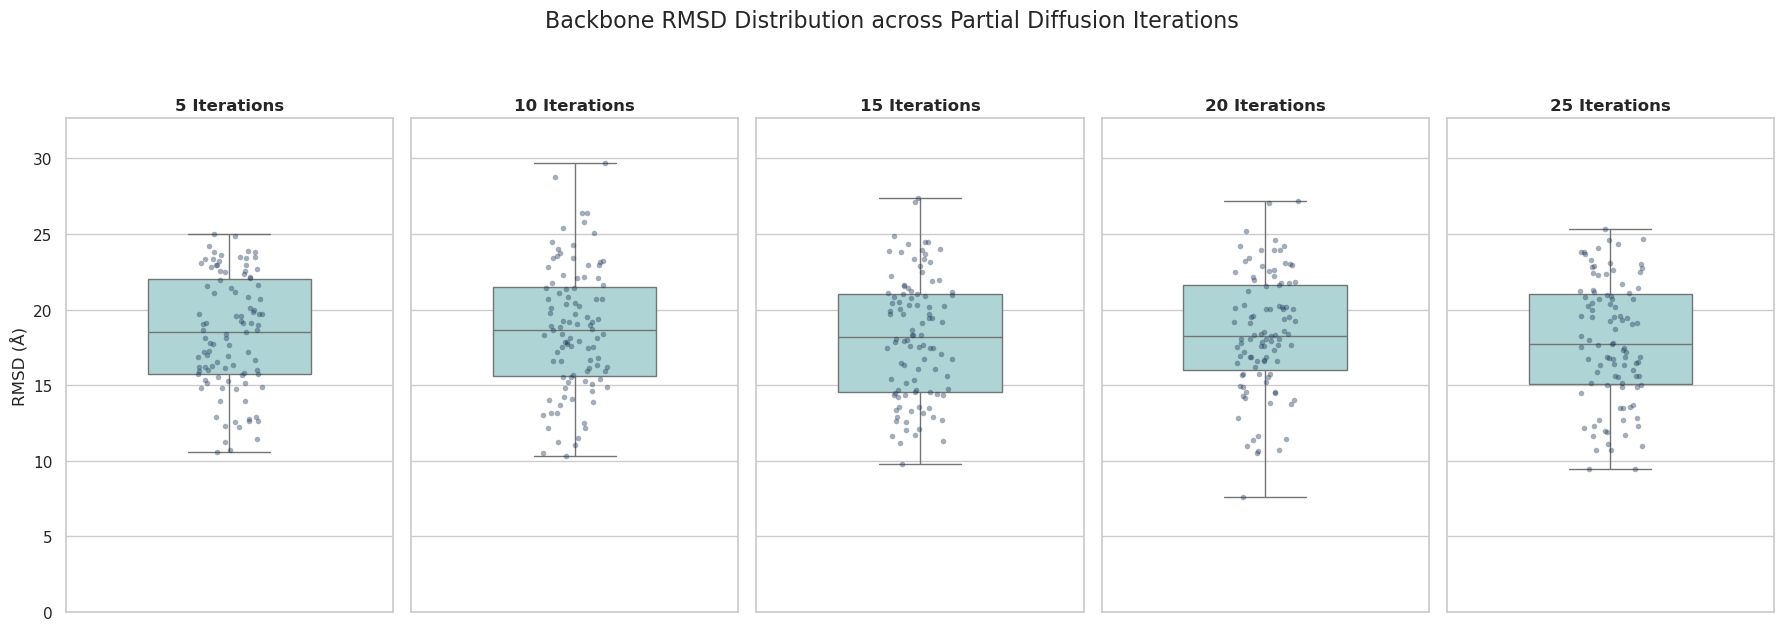

In [ ]:
# Set aesthetics
sns.set_theme(style="whitegrid")

# Data pairs - assuming variables rmsd_10, rmsd_15, rmsd_20, rmsd_25 are defined
rmsds = [rmsd_5, rmsd_10, rmsd_15[:100], rmsd_20, rmsd_25]
titles = ["5 Iterations", "10 Iterations", "15 Iterations", "20 Iterations", "25 Iterations"]
# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(18, 6), sharey=True)

for ax, data, title in zip(axes, rmsds, titles):
    # Main boxplot
    sns.boxplot(y=data, ax=ax, color='#a8dadc', width=0.5, showfliers=False)
    # Individual points
    sns.stripplot(y=data, ax=ax, color='#1d3557', alpha=0.4, jitter=True, size=4)
    
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel("RMSD (Å)") if ax == axes[0] else ax.set_ylabel("")
    ax.set_ylim(0, max([np.max(d) for d in rmsds]) * 1.1)

plt.suptitle("Backbone RMSD Distribution across Partial Diffusion Iterations", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# Test RFDiffusion3 for GPC3

* PDB: correct_uniprot_gpc3_59-477_renum.pdb
* Hotspots: 67,71,147,153,156,275
* binder length: 60-150

In [ ]:
from rfd3.engine import RFD3InferenceConfig, RFD3InferenceEngine

In [ ]:
from rfd3.engine import RFD3InferenceConfig, RFD3InferenceEngine

config = RFD3InferenceConfig(
    specification={
        "dialect": 2,
        "infer_ori_strategy": "hotspots",
        "input": "/home/ubuntu/cancer/gpc3/rfd3_test/correct_uniprot_gpc3_59-477_renum.pdb",
        "contig": "50-150,/0,A1-419",
        "select_hotspots": "A67,A71,A147,A153,A156,A275",
    },
    diffusion_batch_size=1,
)

model = RFD3InferenceEngine(**config)
outputs = model.run(
    inputs=None,
    out_dir=None,
    n_batches=1,
)

Using bfloat16 Automatic Mixed Precision (AMP)


KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/_zmq.py", line 179, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 
09:30:57 WARNING atomworks.io: We can't fix formal charges without building from templates, as we need to know the true number of hydrogens bonded to a given atom, not the inferred number. This may lead to occasional inaccuracies after adding inter-residue bonds. To avoid this and fix formal charges, set `add_missing_atoms = True`.
09:30:58 WARNING atomworks.io: The `extra_fields` argument will be ignored if there is no CIF file input.
09:30:58 WARNING atomworks.ml: Cached data not found for ALA at /net/tukwila/ncorley/datahub/MACE-OFF23_medium/A/ALA/ALA.pt
09:30:58 WARNING atomworks.ml: Cached data not found for ARG at /net/tukwila/ncorley/datahub/MACE-OFF23_medium/A/ARG/ARG.pt
09:30:58 WARNING atomworks.ml: Cached data not found for ASN at /net/tukwila/ncorley/datahub/MACE-OFF23_med

In [ ]:
first_key = next(iter(outputs.keys()))
atom_array = outputs[first_key][0].atom_array

In [ ]:
from mpnn.inference_engines.mpnn import MPNNInferenceEngine

engine_config = {
    'model_type': "protein_mpnn",
    "is_legacy_weights": True,
    "out_directory": "new",
    "write_structures": True,
    "write_fasta": False,
}

input_configs = [
    {
        "batch_size": 8,
        "remove_waters": True,
        "fixed_chains": ["B"],
        "temperature": 0.001,
    }
]

model = MPNNInferenceEngine(**engine_config)
mpnn_outputs = model.run(input_dicts=input_configs, atom_arrays=[atom_array])

In [ ]:
from biotite.structure import get_residue_starts
from biotite.sequence import ProteinSequence

# Extract and display the designed sequences
print(f"Generated {len(mpnn_outputs)} designed sequences:\n")

for i, item in enumerate(mpnn_outputs):
    res_starts = get_residue_starts(item.atom_array)
    # Convert 3-letter codes to 1-letter using Biotite
    seq_1letter = ''.join(
        ProteinSequence.convert_letter_3to1(res_name)
        for res_name in item.atom_array.res_name[res_starts]
    )
    print(f"Sequence {i+1}: {seq_1letter}")

Generated 8 designed sequences:

Sequence 1: NFLKKLQKEGIIEEEEAKKMGVSEEFLKELEENNYITSLEIDGKTYYRITLLGIKYAKENNLGSDLQVCLPKGPTCCSRKMEEKYQLTARLNMEQLLQSASMELKFLIIQNAAVFQEAFEIVVRHAKNYTNAMFKNNYPSLTPQAFEFVGEFFTDVSLYILGSDINVDDMVNELFDSLFPVIYTQLMNPGLPDSALDINECLRGARRDLKVFGNFPKLIMTQVSKSLQVTRIFLQALNLGIEVINTTDHLKFSKDCGRMLTRMWYCSYCQGLMMVKPCGGYCNVVMQGCMAGVVEIDKYWREYILSLEELVNGMYRIYDMENVLLGLFSTIHDSIQYVQKNAGKLTTTIGKLCAHSQQRQYRSAYYPEDLFIDKKVLKVAHVEHEETLSSRRRELIQKLKSFISFYSALPGYICSHSPVAENDTLCWNGQELVERYSQKAARNGMKNQFNLHELKMKGPEPVVSQIIDKLKHINQLLRTMS
Sequence 2: KVLQEIKKKGKITLEEAKEMGMSEETIKELIENNYIISIEEDGKTYLVITKEGIDYMKKNGLGSDLQVCLPKGPTCCSRKMEEKYQLTARLNMEQLLQSASMELKFLIIQNAAVFQEAFEIVVRHAKNYTNAMFKNNYPSLTPQAFEFVGEFFTDVSLYILGSDINVDDMVNELFDSLFPVIYTQLMNPGLPDSALDINECLRGARRDLKVFGNFPKLIMTQVSKSLQVTRIFLQALNLGIEVINTTDHLKFSKDCGRMLTRMWYCSYCQGLMMVKPCGGYCNVVMQGCMAGVVEIDKYWREYILSLEELVNGMYRIYDMENVLLGLFSTIHDSIQYVQKNAGKLTTTIGKLCAHSQQRQYRSAYYPEDLFIDKKVLKVAHVEHEETLSSRRRELIQKLKSFISFYSALPGYICSHSPVAENDTLCWNGQELVERYSQKAARNGMKNQFNLHELKMKGPEP

In [ ]:
from rf3.inference_engines.rf3 import RF3InferenceEngine
from rf3.utils.inference import InferenceInput

In [ ]:
inference_engine = RF3InferenceEngine(ckpt_path='rf3', verbose=False)

In [ ]:
inference_engine.run?

Signature:
inference_engine.run(
    inputs: rf3.utils.inference.InferenceInput | list[rf3.utils.inference.InferenceInput] | biotite.structure.AtomArray | list[biotite.structure.AtomArray] | os.PathLike | list[os.PathLike],
    out_dir: os.PathLike | None = None,
    dump_predictions: bool = True,
    dump_trajectories: bool = False,
    one_model_per_file: bool = False,
    annotate_b_factor_with_plddt: bool = False,
    sharding_pattern: str | None = None,
    skip_existing: bool = False,
    template_selection: list[str] | str | None = None,
    ground_truth_conformer_selection: list[str] | str | None = None,
    cyclic_chains: list[str] = [],
) -> dict[str, dict] | None
Docstring:
Run inference on inputs.

Requires a pre-initialized inference engine.

Args:
  inputs: Single/list of InferenceInput objects, AtomArray objects, file paths, or directory.
  out_dir: Output directory. If None, returns results as an AtomArray and dictionaries of metrics. Defaults to ``None``.
  dump_predic

In [ ]:
input_structure = InferenceInput.from_atom_array(atom_array, example_id="gpc3_binder", template_selection=["B"])
#rf3_outputs = inference_engine.run(inputs=input_structure)
rf3_outputs = inference_engine.run(inputs=input_structure)

04:54:52 WARNING atomworks.io: The `extra_fields` argument will be ignored if there is no CIF file input.
04:54:52 WARNING atomworks.io: Adding missing atoms will erase extra fields. If you just want to load a structure with the given extra fields, you should probably use the much faster 'load_any' function from atomworks.io.utils.io_utils instead of 'parse'. Parse is meant for cleaning up structures from the RCSB PDB.
04:54:52 INFO rf3.inference_engines.rf3: [rank: 0] Loading checkpoint from /home/ubuntu/.foundry/checkpoints/rf3_foundry_01_24_latest_remapped.ckpt...
04:54:53 WARNING atomworks.ml: Using element type for atom names of atomized tokens.
04:54:56 WARNING rf3.inference_engines.rf3: [rank: 0] out_dir is None - results will be returned in memory! If you want to save to disk, please provide an out_dir.
04:54:56 INFO rf3.inference_engines.rf3: [rank: 0] Found 1 structures to predict!
04:54:56 INFO rf3.inference_engines.rf3: [rank: 0] Predicting structure 1/1: gpc3_binder
04:54:

In [ ]:
rf3_output = rf3_outputs["gpc3_binder"][0]

In [ ]:
# Summary confidences: overall model quality metrics
summary = rf3_output.summary_confidences

print("=== Summary Confidences ===")
print(f"  Overall pLDDT:    {summary['overall_plddt']:.3f}")
print(f"  Overall PAE:      {summary['overall_pae']:.2f} A")
print(f"  Overall PDE:      {summary['overall_pde']:.3f}")
print(f"  pTM:              {summary['ptm']:.3f}")
print(f"  ipTM:             {summary.get('iptm', 'N/A (single chain)')}")
print(f"  Ranking score:    {summary['ranking_score']:.3f}")
print(f"  Has clash:        {summary['has_clash']}")

=== Summary Confidences ===
  Overall pLDDT:    0.808
  Overall PAE:      8.83 A
  Overall PDE:      3.426
  pTM:              0.843
  ipTM:             0.23870883882045746
  Ranking score:    0.359
  Has clash:        False


In [ ]:
from biotite.structure import rmsd, superimpose
from atomworks.constants import PROTEIN_BACKBONE_ATOM_NAMES
import numpy as np

aa_generated = atom_array              # Original RFD3 backbone (from Section 1)
aa_refolded = rf3_output.atom_array    # RF3-predicted structure

chA_generated = aa_generated[np.isin(aa_generated.chain_id,"A")]
bb_chA_generated = chA_generated[np.isin(chA_generated.atom_name, PROTEIN_BACKBONE_ATOM_NAMES)]

chA_refolded = aa_refolded[np.isin(aa_refolded.chain_id,"A")]
bb_chA_refolded = chA_refolded[np.isin(chA_refolded.atom_name, PROTEIN_BACKBONE_ATOM_NAMES)]

bb_refolded_fitted, _ = superimpose(bb_chA_generated, bb_chA_refolded)
rmsd_value = rmsd(bb_chA_generated, bb_chA_refolded)

print(f"Backbone RMSD: {rmsd_value:.2f} A")


Backbone RMSD: 19.24 A


In [ ]:
res_starts = get_residue_starts(chA_generated)
# Convert 3-letter codes to 1-letter using Biotite
seq_1letter = ''.join(
    ProteinSequence.convert_letter_3to1(res_name)
    for res_name in chA_generated.res_name[res_starts]
)

In [ ]:
rf3_output.summary_confidences['bb_sc_rmsd'] = rmsd_value.item()
rf3_output.summary_confidences['name'] = "xyz"
rf3_output.summary_confidences['binder_sequence'] = seq_1letter
rf3_output.summary_confidences['sequence_length'] = len(seq_1letter)


In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(rf3_output.summary_confidences)

In [ ]:
rf3_output.summary_confidences

{'chain_ptm': [0.68, 0.82],
 'chain_pair_pae_min': [[None, 19.18], [None, None]],
 'chain_pair_pde_min': [[None, 9.94], [None, None]],
 'chain_pair_pae': [[None, 24.23], [None, None]],
 'chain_pair_pde': [[None, 13.37], [None, None]],
 'overall_plddt': 0.8079,
 'overall_pde': 3.4261,
 'overall_pae': 8.8338,
 'ptm': 0.8425129652023315,
 'iptm': 0.23870883882045746,
 'has_clash': False,
 'ranking_score': 0.3595,
 'bb_sc_rmsd': 19.243741989135742,
 'name': 'xyz',
 'binder_sequence': 'MVINKIITEGSLELSELLKLGASAATIDELIANASVVALNLDSQTLFAATAAGIAYAINTQA',
 'sequence_length': 62}

In [ ]:
df.to_csv("output.csv", index=False) 

In [ ]:
from atomworks.io.utils.io_utils import to_cif_file

# Export structures to CIF format for visualization in PyMOL/ChimeraX
to_cif_file(aa_generated, "generated.cif")
to_cif_file(aa_refolded, "refolded.cif")

'/paperspace/Desktop/cancer/gpc3/rfd3_test/refolded.cif'

# Final run

In [ ]:
def rfdiffusion(pdb, contig, hotspots, n_mpnn, fixed_chains, struct_ID, job_ID):

    import numpy as np
    import pandas as pd
    
    from rfd3.engine import RFD3InferenceConfig, RFD3InferenceEngine
    from mpnn.inference_engines.mpnn import MPNNInferenceEngine
    from rf3.inference_engines.rf3 import RF3InferenceEngine
    from rf3.utils.inference import InferenceInput
    
    from biotite.structure import get_residue_starts
    from biotite.sequence import ProteinSequence
    from biotite.structure import rmsd, superimpose

    from atomworks.constants import PROTEIN_BACKBONE_ATOM_NAMES
    from atomworks.io.utils.io_utils import to_cif_file
    

    ID=f"job_{job_ID}-struct_{struct_ID}"

    # Run RFD3
    config = RFD3InferenceConfig(
        specification={
            "dialect": 2,
            "infer_ori_strategy": "hotspots",
            "input": pdb,
            "contig": contig,
            "select_hotspots": hotspots,
        },
        diffusion_batch_size=1,
    )

    model = RFD3InferenceEngine(**config)
    outputs = model.run(
        inputs=None,
        out_dir=None,
        n_batches=1,
    )

    first_key = next(iter(outputs.keys()))
    atom_array = outputs[first_key][0].atom_array

    # Run MPNN
    engine_config = {
        'model_type': "protein_mpnn",
        "is_legacy_weights": True,
        "out_directory": "new",
        "write_structures": True,
        "write_fasta": False,
    }

    input_configs = [
        {
            "batch_size": n_mpnn,
            "remove_waters": True,
            "fixed_chains": [fixed_chains],
            "temperature": 0.001,
        }
    ]

    model = MPNNInferenceEngine(**engine_config)
    mpnn_outputs = model.run(input_dicts=input_configs, atom_arrays=[atom_array])

    #Run RF3
    inference_engine = RF3InferenceEngine(ckpt_path='rf3', verbose=False)

    input_structure = InferenceInput.from_atom_array(atom_array, example_id="binder")
    rf3_outputs = inference_engine.run(inputs=input_structure)

    rf3_output = rf3_outputs["binder"][0]

    #Calculate RMSD
    aa_generated = atom_array              # Original RFD3 backbone (from Section 1)
    aa_refolded = rf3_output.atom_array    # RF3-predicted structure

    chA_generated = aa_generated[np.isin(aa_generated.chain_id,"A")]
    bb_chA_generated = chA_generated[np.isin(chA_generated.atom_name, PROTEIN_BACKBONE_ATOM_NAMES)]

    chA_refolded = aa_refolded[np.isin(aa_refolded.chain_id,"A")]
    bb_chA_refolded = chA_refolded[np.isin(chA_refolded.atom_name, PROTEIN_BACKBONE_ATOM_NAMES)]

    bb_refolded_fitted, _ = superimpose(bb_chA_generated, bb_chA_refolded)
    rmsd_value = rmsd(bb_chA_generated, bb_chA_refolded)

    res_starts = get_residue_starts(chA_generated)
    seq_1letter = ''.join(
        ProteinSequence.convert_letter_3to1(res_name)
        for res_name in chA_generated.res_name[res_starts]
    )

    rf3_output.summary_confidences['bb_sc_rmsd'] = rmsd_value.item()
    rf3_output.summary_confidences['binder_sequence'] = seq_1letter
    rf3_output.summary_confidences['sequence_length'] = len(seq_1letter)
    rf3_output.summary_confidences['name'] = ID

    #Save metric file
    df = pd.DataFrame(rf3_output.summary_confidences)
    df.to_csv(f"{ID}_metrics.csv", index=False) 

    # Export structures to CIF format for visualization in PyMOL/ChimeraX
    to_cif_file(aa_generated, f"{ID}_generated.cif")
    to_cif_file(aa_refolded, f"{ID}_refolded.cif")

In [ ]:
rfdiffusion("/home/ubuntu/cancer/gpc3/rfd3_test/correct_uniprot_gpc3_59-477_renum.pdb", "50-150,/0,A1-419", "A67,A71,A147,A153,A156,A275", 8, "B", 108, 72)

04:45:26 WARNING atomworks.io: We can't fix formal charges without building from templates, as we need to know the true number of hydrogens bonded to a given atom, not the inferred number. This may lead to occasional inaccuracies after adding inter-residue bonds. To avoid this and fix formal charges, set `add_missing_atoms = True`.
04:45:26 WARNING atomworks.io: The `extra_fields` argument will be ignored if there is no CIF file input.
04:45:26 WARNING atomworks.ml: Cached data not found for ALA at /net/tukwila/ncorley/datahub/MACE-OFF23_medium/A/ALA/ALA.pt
04:45:26 WARNING atomworks.ml: Cached data not found for ARG at /net/tukwila/ncorley/datahub/MACE-OFF23_medium/A/ARG/ARG.pt
04:45:26 WARNING atomworks.ml: Cached data not found for ASN at /net/tukwila/ncorley/datahub/MACE-OFF23_medium/A/ASN/ASN.pt
04:45:26 WARNING atomworks.ml: Cached data not found for ASP at /net/tukwila/ncorley/datahub/MACE-OFF23_medium/A/ASP/ASP.pt
04:45:26 WARNING atomworks.ml: Cached data not found for CYS at 

# MPNN and RFD3 from a pdb

In [ ]:
import numpy as np
import pandas as pd

from biotite.structure.io import load_structure
from mpnn.inference_engines.mpnn import MPNNInferenceEngine
from rf3.inference_engines.rf3 import RF3InferenceEngine
from rf3.utils.inference import InferenceInput

from biotite.structure import get_residue_starts
from biotite.sequence import ProteinSequence
from biotite.structure import rmsd, superimpose

from atomworks.constants import PROTEIN_BACKBONE_ATOM_NAMES
from atomworks.io.utils.io_utils import to_cif_file

Environment variable CCD_MIRROR_PATH not set. Will not be able to use function requiring this variable. To set it you may:
  (1) add the line 'export VAR_NAME=path/to/variable' to your .bashrc or .zshrc file
  (2) set it in your current shell with 'export VAR_NAME=path/to/variable'
  (3) write it to a .env file in the root of the atomworks.io repository
Environment variable PDB_MIRROR_PATH not set. Will not be able to use function requiring this variable. To set it you may:
  (1) add the line 'export VAR_NAME=path/to/variable' to your .bashrc or .zshrc file
  (2) set it in your current shell with 'export VAR_NAME=path/to/variable'
  (3) write it to a .env file in the root of the atomworks.io repository
05:59:59 INFO rdkit: Enabling RDKit 2025.03.6 jupyter extensions


In [ ]:
path = "./generated.cif"
x = load_structure(path)
atom_array = x

In [ ]:
engine_config = {
    'model_type': "protein_mpnn",
    "is_legacy_weights": True,
    "out_directory": "new",
    "write_structures": True,
    "write_fasta": False,
}

input_configs = [
    {
        "batch_size": 8,
        "remove_waters": True,
        "fixed_chains": ["B"],
        "temperature": 0.001,
    }
]

model = MPNNInferenceEngine(**engine_config)
mpnn_outputs = model.run(input_dicts=input_configs, atom_arrays=[atom_array])

06:00:02 INFO mpnn.inference_engines.mpnn: [rank: 0] Loading legacy MPNN weights.
06:00:05 INFO mpnn.utils.inference: Annotated AtomArray has 7715 atoms 
06:00:05 INFO mpnn.inference_engines.mpnn: [rank: 0] Running MPNN inference for input 0, batch 0...


In [ ]:
print(f"Generated {len(mpnn_outputs)} designed sequences:\n")

for i, item in enumerate(mpnn_outputs):
    res_starts = get_residue_starts(item.atom_array)
    # Convert 3-letter codes to 1-letter using Biotite
    seq_1letter = ''.join(
        ProteinSequence.convert_letter_3to1(res_name)
        for res_name in item.atom_array.res_name[res_starts]
    )
    print(f"Sequence {i+1}: {seq_1letter}")

Generated 8 designed sequences:

Sequence 1: NVLKKIVEKGLITYEEAKKMGMSDEEIKKLIEENKIVSLEINGKKYYRITLAGIKYMKENNIGSDLQVCLPKGPTCCSRKMEEKYQLTARLNMEQLLQSASMELKFLIIQNAAVFQEAFEIVVRHAKNYTNAMFKNNYPSLTPQAFEFVGEFFTDVSLYILGSDINVDDMVNELFDSLFPVIYTQLMNPGLPDSALDINECLRGARRDLKVFGNFPKLIMTQVSKSLQVTRIFLQALNLGIEVINTTDHLKFSKDCGRMLTRMWYCSYCQGLMMVKPCGGYCNVVMQGCMAGVVEIDKYWREYILSLEELVNGMYRIYDMENVLLGLFSTIHDSIQYVQKNAGKLTTTIGKLCAHSQQRQYRSAYYPEDLFIDKKVLKVAHVEHEETLSSRRRELIQKLKSFISFYSALPGYICSHSPVAENDTLCWNGQELVERYSQKAARNGMKNQFNLHELKMKGPEPVVSQIIDKLKHINQLLRTMS
Sequence 2: NVLKKIVEKGKITYEEAKKMGMSDEEIEELIKNNYIISIEEDGKKYLVITKLGIEYRKKNNLGSDLQVCLPKGPTCCSRKMEEKYQLTARLNMEQLLQSASMELKFLIIQNAAVFQEAFEIVVRHAKNYTNAMFKNNYPSLTPQAFEFVGEFFTDVSLYILGSDINVDDMVNELFDSLFPVIYTQLMNPGLPDSALDINECLRGARRDLKVFGNFPKLIMTQVSKSLQVTRIFLQALNLGIEVINTTDHLKFSKDCGRMLTRMWYCSYCQGLMMVKPCGGYCNVVMQGCMAGVVEIDKYWREYILSLEELVNGMYRIYDMENVLLGLFSTIHDSIQYVQKNAGKLTTTIGKLCAHSQQRQYRSAYYPEDLFIDKKVLKVAHVEHEETLSSRRRELIQKLKSFISFYSALPGYICSHSPVAENDTLCWNGQELVERYSQKAARNGMKNQFNLHELKMKGPEP

In [ ]:
inference_engine = RF3InferenceEngine(ckpt_path='rf3', verbose=False)
input_structure = InferenceInput.from_atom_array(mpnn_outputs[2].atom_array,example_id="binder", template_selection="B")
rf3_outputs = inference_engine.run(inputs=input_structure)

06:17:49 WARNING atomworks.io: The `extra_fields` argument will be ignored if there is no CIF file input.
06:17:49 WARNING atomworks.io: Adding missing atoms will erase extra fields. If you just want to load a structure with the given extra fields, you should probably use the much faster 'load_any' function from atomworks.io.utils.io_utils instead of 'parse'. Parse is meant for cleaning up structures from the RCSB PDB.


06:17:49 INFO rf3.inference_engines.rf3: [rank: 0] Loading checkpoint from /home/ubuntu/.foundry/checkpoints/rf3_foundry_01_24_latest_remapped.ckpt...
06:17:50 WARNING atomworks.ml: Using element type for atom names of atomized tokens.
Using bfloat16 Automatic Mixed Precision (AMP)
06:17:53 WARNING rf3.inference_engines.rf3: [rank: 0] out_dir is None - results will be returned in memory! If you want to save to disk, please provide an out_dir.
06:17:53 INFO rf3.inference_engines.rf3: [rank: 0] Found 1 structures to predict!
06:17:53 INFO rf3.inference_engines.rf3: [rank: 0] Predicting structure 1/1: binder
06:17:53 WARNING atomworks.ml: Cached data not found for ALA at /net/tukwila/lschaaf/datahub/MACE-OMOL-Jul2025/mace_embeddings/A/ALA/ALA.pt
06:17:53 WARNING atomworks.ml: Cached data not found for ARG at /net/tukwila/lschaaf/datahub/MACE-OMOL-Jul2025/mace_embeddings/A/ARG/ARG.pt
06:17:53 WARNING atomworks.ml: Cached data not found for ASN at /net/tukwila/lschaaf/datahub/MACE-OMOL-Jul2

In [ ]:
rf3_output = rf3_outputs['binder'][0]
res_starts = get_residue_starts(rf3_output.atom_array)
    # Convert 3-letter codes to 1-letter using Biotite
seq_1letter = ''.join(
    ProteinSequence.convert_letter_3to1(res_name)
    for res_name in rf3_output.atom_array.res_name[res_starts]
)
print(f"Sequence {i+1}: {seq_1letter}")

Sequence 8: GFLKKLVENGYITYEEAKEMGVSDETLEYLIENNYITSIEENGKTLYVITLEGIKYMKENNLGSDLQVCLPKGPTCCSRKMEEKYQLTARLNMEQLLQSASMELKFLIIQNAAVFQEAFEIVVRHAKNYTNAMFKNNYPSLTPQAFEFVGEFFTDVSLYILGSDINVDDMVNELFDSLFPVIYTQLMNPGLPDSALDINECLRGARRDLKVFGNFPKLIMTQVSKSLQVTRIFLQALNLGIEVINTTDHLKFSKDCGRMLTRMWYCSYCQGLMMVKPCGGYCNVVMQGCMAGVVEIDKYWREYILSLEELVNGMYRIYDMENVLLGLFSTIHDSIQYVQKNAGKLTTTIGKLCAHSQQRQYRSAYYPEDLFIDKKVLKVAHVEHEETLSSRRRELIQKLKSFISFYSALPGYICSHSPVAENDTLCWNGQELVERYSQKAARNGMKNQFNLHELKMKGPEPVVSQIIDKLKHINQLLRTMS


In [ ]:
rf3_output = rf3_outputs['binder'][0]
res_starts = get_residue_starts(rf3_output.atom_array)
    # Convert 3-letter codes to 1-letter using Biotite
seq_1letter = ''.join(
    ProteinSequence.convert_letter_3to1(res_name)
    for res_name in rf3_output.atom_array.res_name[res_starts]
)
print(f"Sequence {i+1}: {seq_1letter}")

Sequence 8: MVINKIITEGSLELSELLKLGASAATIDELIANASVVALNLDSQTLFAATAAGIAYAINTQAGSDLQVCLPKGPTCCSRKMEEKYQLTARLNMEQLLQSASMELKFLIIQNAAVFQEAFEIVVRHAKNYTNAMFKNNYPSLTPQAFEFVGEFFTDVSLYILGSDINVDDMVNELFDSLFPVIYTQLMNPGLPDSALDINECLRGARRDLKVFGNFPKLIMTQVSKSLQVTRIFLQALNLGIEVINTTDHLKFSKDCGRMLTRMWYCSYCQGLMMVKPCGGYCNVVMQGCMAGVVEIDKYWREYILSLEELVNGMYRIYDMENVLLGLFSTIHDSIQYVQKNAGKLTTTIGKLCAHSQQRQYRSAYYPEDLFIDKKVLKVAHVEHEETLSSRRRELIQKLKSFISFYSALPGYICSHSPVAENDTLCWNGQELVERYSQKAARNGMKNQFNLHELKMKGPEPVVSQIIDKLKHINQLLRTMS


In [ ]:
res_starts = get_residue_starts(atom_array)
    # Convert 3-letter codes to 1-letter using Biotite
seq_1letter = ''.join(
    ProteinSequence.convert_letter_3to1(res_name)
    for res_name in atom_array.res_name[res_starts]
)
print(f"Sequence {i+1}: {seq_1letter}")

Sequence 8: MVINKIITEGSLELSELLKLGASAATIDELIANASVVALNLDSQTLFAATAAGIAYAINTQAGSDLQVCLPKGPTCCSRKMEEKYQLTARLNMEQLLQSASMELKFLIIQNAAVFQEAFEIVVRHAKNYTNAMFKNNYPSLTPQAFEFVGEFFTDVSLYILGSDINVDDMVNELFDSLFPVIYTQLMNPGLPDSALDINECLRGARRDLKVFGNFPKLIMTQVSKSLQVTRIFLQALNLGIEVINTTDHLKFSKDCGRMLTRMWYCSYCQGLMMVKPCGGYCNVVMQGCMAGVVEIDKYWREYILSLEELVNGMYRIYDMENVLLGLFSTIHDSIQYVQKNAGKLTTTIGKLCAHSQQRQYRSAYYPEDLFIDKKVLKVAHVEHEETLSSRRRELIQKLKSFISFYSALPGYICSHSPVAENDTLCWNGQELVERYSQKAARNGMKNQFNLHELKMKGPEPVVSQIIDKLKHINQLLRTMS
